In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random
from collections import Counter

import seaborn as sns
COLORS = sns.color_palette()

In [2]:
# Create a histogram class inherited from Counter
class Hist(Counter):
    
    def __add__(self, other):
        """Returns the Pmf of the sum of elements from self and other."""
        return Hist(x + y for x, y in product(self.elements(), other.elements()))
    
    def choice(self):
        """Chooses a random element."""
        return random.choice(list(self.elements()))
    
    def plot(self, **options):
        """Plots the Pmf."""
        plt.bar(*zip(*self.items()), **options)
        plt.xlabel('Values')
        plt.ylabel('Counts')
    
    def ranks(self):
        """Returns ranks and counts as lists."""
        return zip(*enumerate(sorted(self.values(), reverse=True)))
    
    def normalize(self):
        # Function to calculate and return the % breakout for each item
        total = sum(self.values())
        for element in self:
            self[element] /= total
        return self

In [3]:
q117 = pd.DataFrame.from_csv('data/LoanStats_2017Q1.csv', index_col=None, header=1)

# Drop columns where more than 90% of entries are NaN
q117 = q117.dropna(axis=1, thresh=96781*.9)

# Convert int_rate column from strings to floats
q117.int_rate = q117.int_rate.str.strip('%')
q117.int_rate = q117.int_rate.astype(float)

# Drop all rows where int_rate is NaN
q117 = q117.dropna(axis=0, how='any')

# Convert revol_util column from strings to floats
q117.revol_util = q117.revol_util.str.strip('%')
q117.revol_util = q117.revol_util.astype(float)

q117.head()

C:\Users\richa\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2821: DtypeWarning: Columns (0,112) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,3600.0,3600.0,3600.0,36 months,7.49,111.97,A,A4,Code/Compliance Inspector,10+ years,...,0.0,6.0,100.0,0.0,1.0,0.0,93599.0,36506.0,9000.0,55699.0
1,15000.0,15000.0,15000.0,60 months,14.99,356.78,C,C4,Senior Superintendent,10+ years,...,0.0,0.0,100.0,66.7,0.0,0.0,148572.0,69364.0,60300.0,30224.0
2,8400.0,8400.0,8400.0,36 months,11.39,276.56,B,B3,IT Tech,8 years,...,0.0,5.0,100.0,14.3,0.0,0.0,205671.0,51591.0,36100.0,36876.0
3,4000.0,4000.0,4000.0,36 months,10.49,130.00,B,B2,Dental hygienist,2 years,...,0.0,1.0,87.5,100.0,0.0,0.0,152852.0,136208.0,2500.0,139652.0
4,6000.0,6000.0,6000.0,36 months,7.24,185.93,A,A3,Program Manager,3 years,...,0.0,3.0,59.1,20.0,0.0,0.0,72865.0,60622.0,23200.0,49665.0


In [4]:
q117.iloc[:, :10].head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length
0,3600.0,3600.0,3600.0,36 months,7.49,111.97,A,A4,Code/Compliance Inspector,10+ years
1,15000.0,15000.0,15000.0,60 months,14.99,356.78,C,C4,Senior Superintendent,10+ years
2,8400.0,8400.0,8400.0,36 months,11.39,276.56,B,B3,IT Tech,8 years
3,4000.0,4000.0,4000.0,36 months,10.49,130.00,B,B2,Dental hygienist,2 years
4,6000.0,6000.0,6000.0,36 months,7.24,185.93,A,A3,Program Manager,3 years


In [5]:
q117.iloc[:, 10:20].head()

,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state
0,MORTGAGE,120000.0,Not Verified,Mar-2017,Issued,n,other,Other,467xx,IN
1,MORTGAGE,125000.0,Not Verified,Mar-2017,Issued,n,other,Other,064xx,CT
2,MORTGAGE,50000.0,Source Verified,Mar-2017,Issued,n,other,Other,454xx,OH
3,RENT,50000.0,Source Verified,Mar-2017,Issued,n,major_purchase,Major purchase,768xx,TX
4,RENT,125000.0,Source Verified,Mar-2017,Current,n,credit_card,Credit card refinancing,981xx,WA


In [6]:
q117.iloc[:, 20:30].head()

,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status
0,18.90,0.0,Aug-1992,1.0,18.0,1.0,5658.0,14.9,33.0,w
1,17.25,0.0,Sep-1989,0.0,11.0,0.0,53167.0,75.3,18.0,w
2,15.63,0.0,Apr-2005,0.0,14.0,0.0,12831.0,30.3,30.0,w
3,33.61,1.0,Apr-2003,0.0,10.0,1.0,4388.0,33.2,33.0,w
4,9.25,0.0,Jul-2004,1.0,16.0,0.0,9571.0,41.3,27.0,w


In [7]:
q117.iloc[:, 30:40].head()

,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt
0,3600.00,3600.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00
1,15000.00,15000.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00
2,8400.00,8400.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00
3,4000.00,4000.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00
4,5850.27,5850.27,164.21,164.21,149.73,14.48,0.0,0.0,0.0,169.04


In [8]:
q117.iloc[:, 40:50].head()

,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m
0,Apr-2017,Apr-2017,0.0,1.0,INDIVIDUAL,0.0,0.0,36506.0,2.0,6.0
1,Apr-2017,Apr-2017,0.0,1.0,INDIVIDUAL,0.0,0.0,90423.0,0.0,2.0
2,Apr-2017,Apr-2017,0.0,1.0,INDIVIDUAL,0.0,271.0,161061.0,3.0,2.0
3,Apr-2017,Apr-2017,0.0,1.0,INDIVIDUAL,0.0,0.0,136208.0,0.0,4.0
4,May-2017,Apr-2017,0.0,1.0,INDIVIDUAL,0.0,0.0,60622.0,1.0,11.0


In [9]:
q117.iloc[:, 50:60].head()

,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi
0,2.0,6.0,2.0,30848.0,4.0,7.0,1020.0,39.0,37900.0,3.0
1,0.0,1.0,22.0,16197.0,0.0,3.0,15199.0,69.0,70600.0,1.0
2,1.0,2.0,10.0,38760.0,4.0,8.0,5338.0,65.0,42300.0,4.0
3,1.0,2.0,7.0,131820.0,0.0,4.0,2461.0,56.0,13200.0,0.0
4,2.0,2.0,3.0,51051.0,1.0,2.0,6129.0,83.0,23200.0,1.0


In [10]:
q117.iloc[:, 60:70].head()

,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op
0,1.0,4.0,13.0,2147.0,7980.0,11.3,0.0,0.0,166.0,295.0
1,0.0,0.0,4.0,8220.0,13968.0,76.8,0.0,0.0,158.0,245.0
2,1.0,7.0,10.0,12389.0,24145.0,33.1,0.0,0.0,131.0,143.0
3,0.0,1.0,6.0,13621.0,39.0,98.4,0.0,0.0,148.0,163.0
4,1.0,1.0,4.0,3789.0,13629.0,41.3,0.0,0.0,152.0,149.0


In [11]:
q117.iloc[:, 70:80].head()

,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl
0,3.0,2.0,0.0,9.0,0.0,1.0,4.0,2.0,3.0,17.0
1,16.0,16.0,2.0,16.0,0.0,5.0,7.0,6.0,8.0,6.0
2,4.0,4.0,4.0,4.0,0.0,4.0,5.0,7.0,11.0,9.0
3,15.0,7.0,6.0,120.0,1.0,1.0,4.0,1.0,3.0,15.0
4,7.0,3.0,0.0,7.0,9.0,3.0,3.0,5.0,5.0,22.0


In [12]:
q117.iloc[:, 80:90].head()

,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75
0,12.0,16.0,4.0,18.0,0.0,0.0,0.0,6.0,100.0,0.0
1,8.0,10.0,7.0,11.0,0.0,0.0,0.0,0.0,100.0,66.7
2,11.0,16.0,5.0,14.0,0.0,0.0,0.0,5.0,100.0,14.3
3,6.0,12.0,4.0,10.0,0.0,0.0,0.0,1.0,87.5,100.0
4,5.0,5.0,3.0,16.0,0.0,0.0,0.0,3.0,59.1,20.0


In [13]:
q117.iloc[:, 90:96].head()

,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1.0,0.0,93599.0,36506.0,9000.0,55699.0
1,0.0,0.0,148572.0,69364.0,60300.0,30224.0
2,0.0,0.0,205671.0,51591.0,36100.0,36876.0
3,0.0,0.0,152852.0,136208.0,2500.0,139652.0
4,0.0,0.0,72865.0,60622.0,23200.0,49665.0


In [14]:
# Experimenting with different ways to get the # of A loans
# Method 1: groupby. Produces a series
q117.groupby(q117[q117.grade=='A'].grade).size()

grade
A    13102
dtype: int64

In [15]:
# Method 2: len. Produces an int
len(q117[q117.grade=='A'].grade)

13102

In [16]:
# Total $ amount of A loans
q117[q117.grade=='A'].loan_amnt.sum()

186992150.0

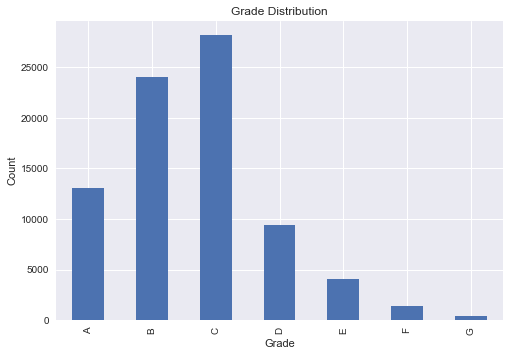

In [17]:
q117.groupby('grade').size().plot(kind='bar')

plt.ylabel('Count')
plt.xlabel('Grade')
plt.title('Grade Distribution')

# Most borrowers fall in grades B and C

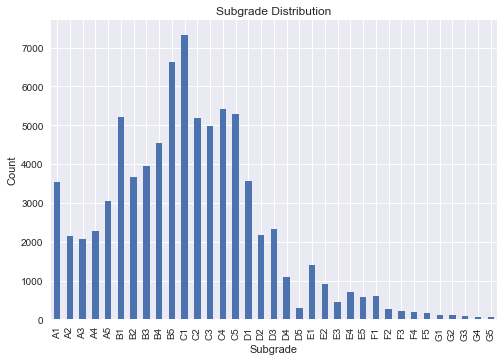

In [18]:
q117.groupby('sub_grade').size().plot(kind='bar')

plt.ylabel('Count')
plt.xlabel('Subgrade')
plt.title('Subgrade Distribution')

# Within B and C, B1, B5 and C1 have the most number of borrowers

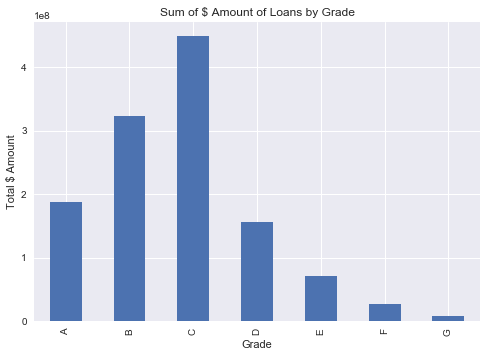

In [19]:
q117.groupby('grade').loan_amnt.sum().plot(kind='bar')

plt.ylabel('Total $ Amount')
plt.xlabel('Grade')
plt.title('Sum of $ Amount of Loans by Grade')

# B and C loans have the highest sums
# This graph looks almost identical to the # of loans distribution by grade

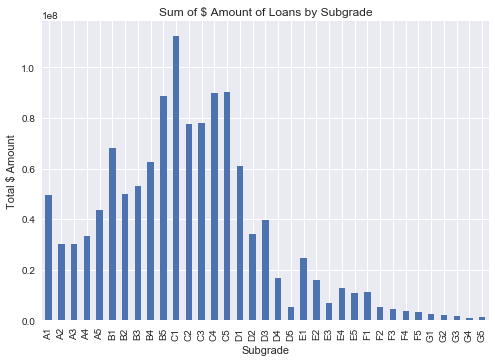

In [20]:
q117.groupby('sub_grade').loan_amnt.sum().plot(kind='bar')

plt.ylabel('Total $ Amount')
plt.xlabel('Subgrade')
plt.title('Sum of $ Amount of Loans by Subgrade')

# B1, B5, and C1 have the highest sums
# Again, this chart is very similar to the distribution of # of loans by subgrade

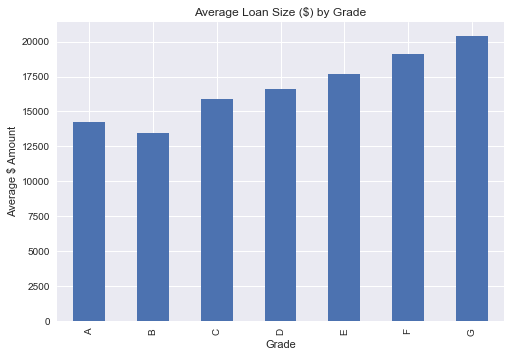

In [21]:
q117.groupby('grade').loan_amnt.mean().plot(kind='bar')

plt.ylabel('Average $ Amount')
plt.xlabel('Grade')
plt.title('Average Loan Size ($) by Grade')

# Average loan size in A, B, and C grades do not vary much
# This explains why $ amount and count distribution charts look very similar
# The least credit-worthy grades ask for larger loans on average

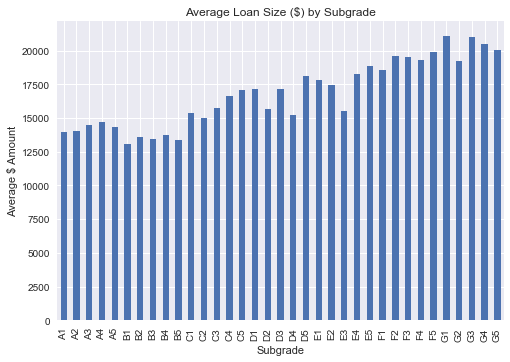

In [22]:
q117.groupby('sub_grade').loan_amnt.mean().plot(kind='bar')

plt.ylabel('Average $ Amount')
plt.xlabel('Subgrade')
plt.title('Average Loan Size ($) by Subgrade')

# Similar findings as above chart: loan size $ by grade

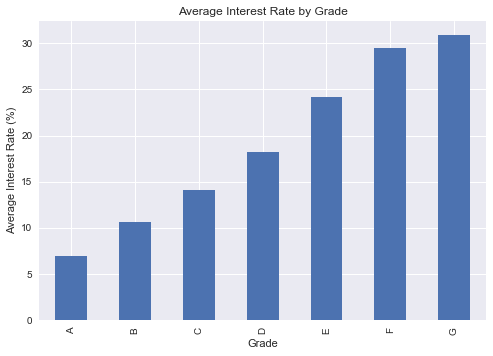

In [23]:
q117.groupby('grade').int_rate.mean().plot(kind='bar')

plt.ylabel('Average Interest Rate (%)')
plt.xlabel('Grade')
plt.title('Average Interest Rate by Grade')

# Confirms that average interest rate increases with grade
# The largest deltas look to be between grades A and B and grades D and E
# There is not much of a difference between F and G

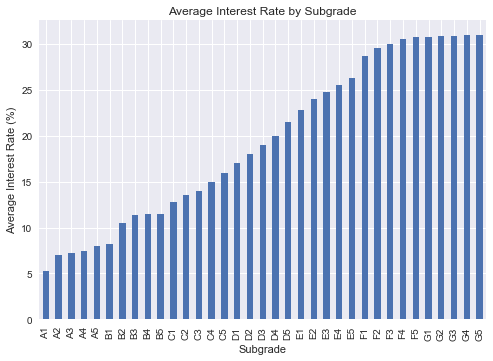

In [24]:
q117.groupby('sub_grade').int_rate.mean().plot(kind='bar')

plt.ylabel('Average Interest Rate (%)')
plt.xlabel('Subgrade')
plt.title('Average Interest Rate by Subgrade')

# Within grades A and B, there is not much of a ramp in interest rates by subgrade
# In grades C through E, there is a steeper ramp of interest rates
# There is not much variance in interest rates within F and G

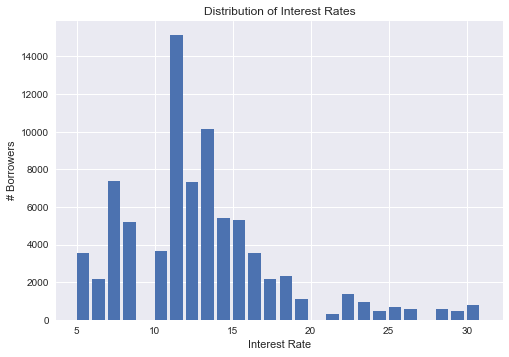

In [25]:
f2, ax2 = plt.subplots()
bins=[x+5 for x in range(27)]
ax2.hist(q117.int_rate, bins, width=0.8)

ax2.set_xlabel('Interest Rate')
ax2.set_ylabel('# Borrowers')
ax2.set_title('Distribution of Interest Rates')

# There are no loans with interest rates between 9-10% and 20-21%

In [26]:
# Create Hist objects with the count of interest rates by grade
a_hist = Hist(q117[q117.grade=='A'].int_rate)
b_hist = Hist(q117[q117.grade=='B'].int_rate)
c_hist = Hist(q117[q117.grade=='C'].int_rate)
d_hist = Hist(q117[q117.grade=='D'].int_rate)
e_hist = Hist(q117[q117.grade=='E'].int_rate)
f_hist = Hist(q117[q117.grade=='F'].int_rate)
g_hist = Hist(q117[q117.grade=='G'].int_rate)

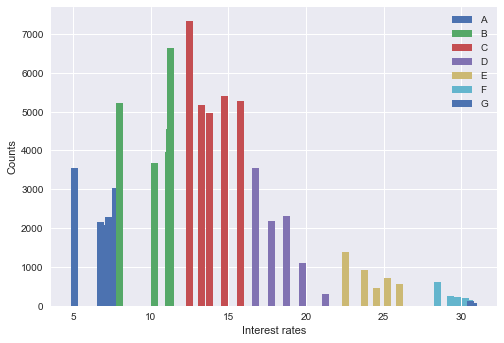

In [27]:
# Plot histogram of interest rate counts by grade
a_hist.plot(width=-0.45, align='edge', label='A')
b_hist.plot(width=-0.45, align='edge', label='B')
c_hist.plot(width=-0.45, align='edge', label='C')
d_hist.plot(width=-0.45, align='edge', label='D')
e_hist.plot(width=-0.45, align='edge', label='E')
f_hist.plot(width=-0.45, align='edge', label='F')
g_hist.plot(width=-0.45, align='edge', label='G')
plt.xlabel('Interest rates')
plt.legend()

# Interest rates increase with the grade
# There are more A, B, and C loans than other grades of loans
# F and G loans have the most similar interest rates

1.81184840417


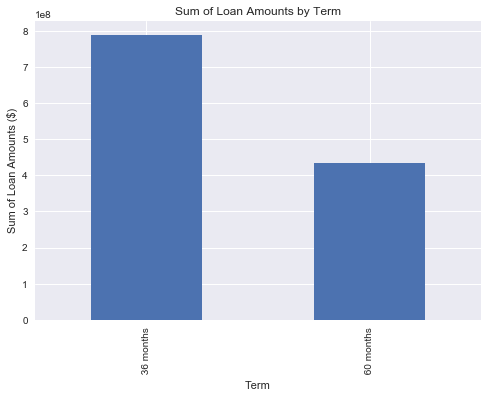

In [28]:
q117.groupby('term').loan_amnt.sum().plot(kind='bar')

plt.ylabel('Sum of Loan Amounts ($)')
plt.xlabel('Term')
plt.title('Sum of Loan Amounts by Term')

print(q117.groupby('term').loan_amnt.sum()[0]/q117.groupby('term').loan_amnt.sum()[1])

# The $ value of 36 month loans is 1.8x higher than the $ value of 60 month loans

2.86891852989


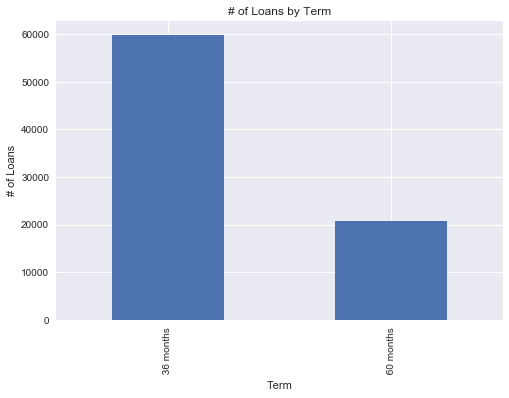

In [29]:
q117.groupby('term').loan_amnt.size().plot(kind='bar')

plt.ylabel('# of Loans')
plt.xlabel('Term')
plt.title('# of Loans by Term')

print(q117.groupby('term').loan_amnt.size()[0]/q117.groupby('term').loan_amnt.size()[1])


# There are more 2.9x more 36 month loans than 60 month loans
# In combination with the previous chart, we can see that while there are 2.8x more 36 month loans than 60 month loans,
# the $ value of 36 month loans is only 1.8x larger
# Thus, 60 month loans must have a higher average $ value

1.58342084431


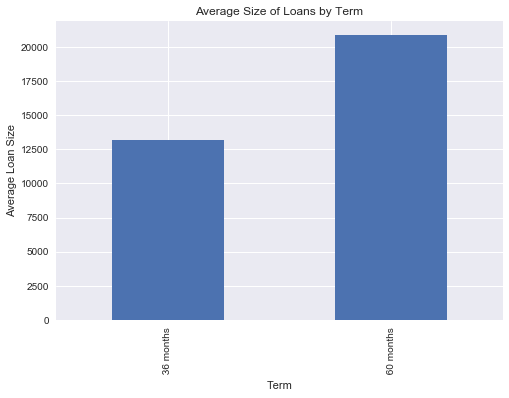

In [30]:
q117.groupby('term').loan_amnt.mean().plot(kind='bar')

plt.ylabel('Average Loan Size')
plt.xlabel('Term')
plt.title('Average Size of Loans by Term')

print(q117.groupby('term').loan_amnt.mean()[1]/q117.groupby('term').loan_amnt.mean()[0])


# Confirm findings from above. 60 month loans have, on average, a 1.6x higher avaerage $ value than 36 month loans

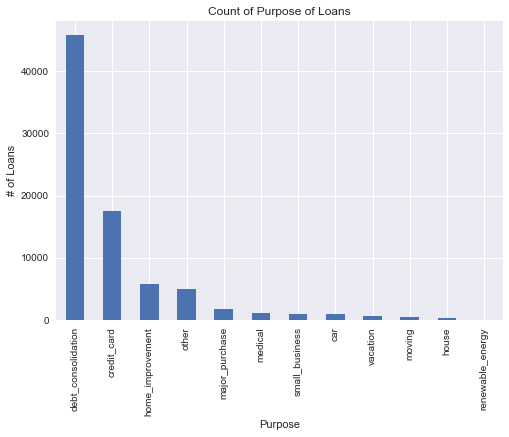

In [31]:
# Experiment by using value_counts instead of groupby
q117.purpose.value_counts().plot(kind='bar')

plt.ylabel('# of Loans')
plt.xlabel('Purpose')
plt.title('Count of Purpose of Loans')

# Debt consolidation and credit card are the most popular uses of loans
# Debt consolidation is by far the largest category

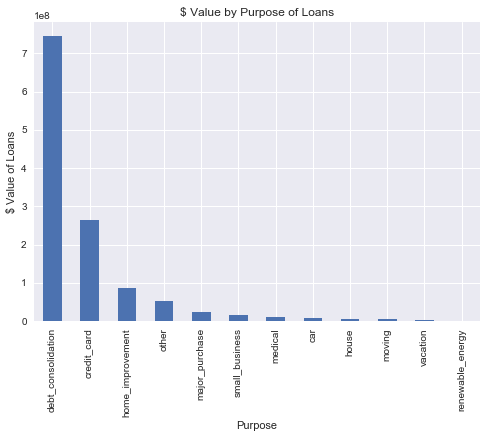

In [32]:
q117.groupby('purpose').loan_amnt.sum().sort_values(ascending=False).plot(kind='bar')

plt.ylabel('$ Value of Loans')
plt.xlabel('Purpose')
plt.title('$ Value by Purpose of Loans')

# Confirm findings from above. This chart and the previous one look very similar

                            OLS Regression Results                            
Dep. Variable:               int_rate   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     71.50
Date:                Tue, 13 Jun 2017   Prob (F-statistic):           2.82e-17
Time:                        16:07:38   Log-Likelihood:            -2.4503e+05
No. Observations:               80636   AIC:                         4.901e+05
Df Residuals:                   80634   BIC:                         4.901e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         13.1952      0.019    694.834      0.0

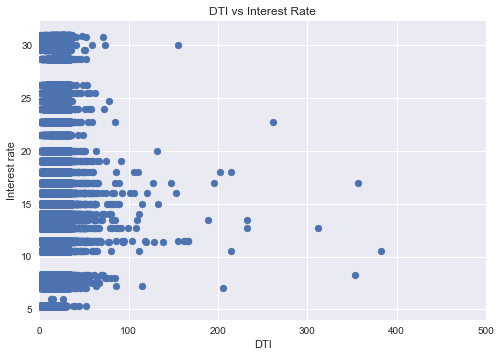

In [33]:
f4, ax4 = plt.subplots()
ax4.scatter(q117.dti, q117.int_rate)

# Set DTI limit of 500
ax4.set_xlim(right=500, left=0)

ax4.set_xlabel('DTI')
ax4.set_ylabel('Interest rate')
ax4.set_title('DTI vs Interest Rate')

# Add stats summary
results = sm.OLS(q117.int_rate,sm.add_constant(q117.dti)).fit()
print(results.summary())

# There is no correlation between DTI and interest rate. R2 is close to 0

In [34]:
# Create Hist objects with count of chargeoffs within 12 months by grade as %s
a_chargeoff_hist = Hist(q117[q117.grade=='A'].chargeoff_within_12_mths).normalize()
b_chargeoff_hist = Hist(q117[q117.grade=='B'].chargeoff_within_12_mths).normalize()
c_chargeoff_hist = Hist(q117[q117.grade=='C'].chargeoff_within_12_mths).normalize()
d_chargeoff_hist = Hist(q117[q117.grade=='D'].chargeoff_within_12_mths).normalize()
e_chargeoff_hist = Hist(q117[q117.grade=='E'].chargeoff_within_12_mths).normalize()
f_chargeoff_hist = Hist(q117[q117.grade=='F'].chargeoff_within_12_mths).normalize()
g_chargeoff_hist = Hist(q117[q117.grade=='G'].chargeoff_within_12_mths).normalize()

(-0.5, 3)

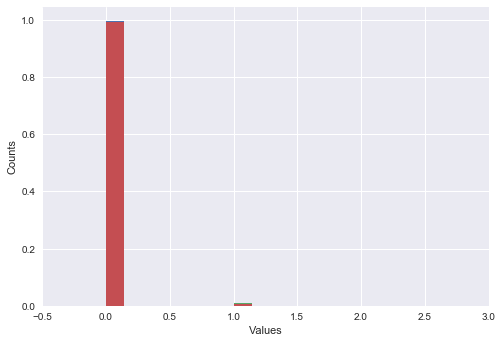

In [35]:
# Work in progress. Goal is to plot PMF of chargeoffs by grade as side by side bars (same graph as below, just shown a different way)

a_chargeoff_hist.plot(width=1/7, align='edge', label='A')
b_chargeoff_hist.plot(width=1/7, align='edge', label='B')
c_chargeoff_hist.plot(width=1/7, align='edge', label='C')
plt.xlim(-0.5, 3)

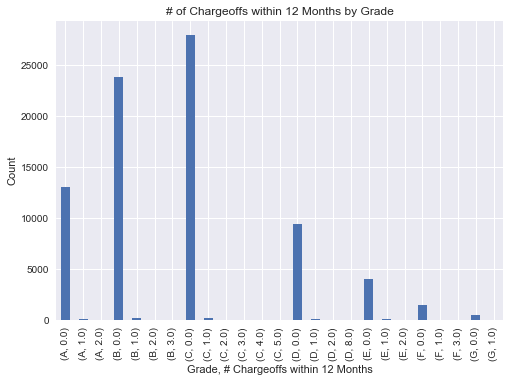

In [36]:
q117.groupby(['grade', 'chargeoff_within_12_mths']).size().plot(kind='bar')

plt.ylabel('Count')
plt.xlabel('Grade, # Chargeoffs within 12 Months')
plt.title('# of Chargeoffs within 12 Months by Grade')

# The majority of borrowers have had 0 chargeoffs within 12 months

In [37]:
q117.groupby(['grade', 'chargeoff_within_12_mths']).size()

# Hard data from chart above

grade  chargeoff_within_12_mths
A      0.0                         13050
       1.0                            49
       2.0                             3
B      0.0                         23788
       1.0                           214
       2.0                            13
       3.0                             4
C      0.0                         27950
       1.0                           216
       2.0                             8
       3.0                             3
       4.0                             2
       5.0                             1
D      0.0                          9364
       1.0                            68
       2.0                             6
       8.0                             1
E      0.0                          4009
       1.0                            30
       2.0                             1
F      0.0                          1426
       1.0                             7
       3.0                             1
G      0.0               

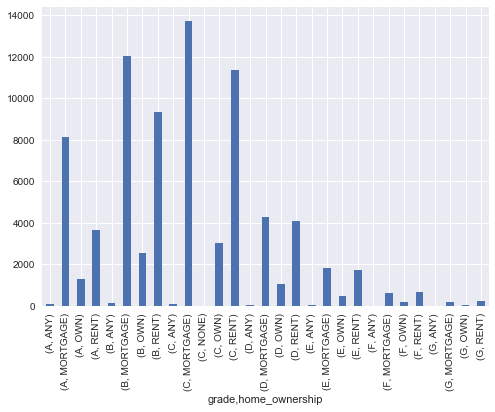

In [38]:
# Plot home ownership type count by grade. Again, would be nice to have this by % breakout
q117.groupby(['grade', 'home_ownership']).size().plot(kind='bar')

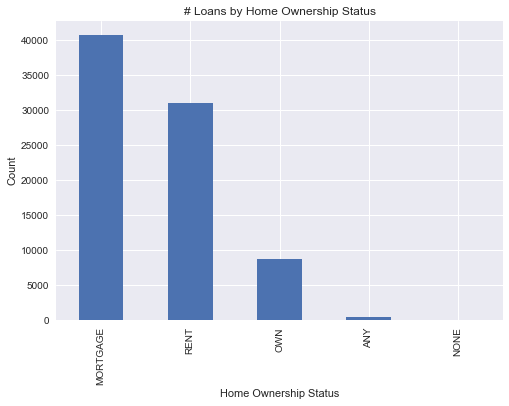

In [39]:
q117.groupby(['home_ownership']).size().sort_values(ascending=False).plot(kind='bar')

plt.ylabel('Count')
plt.xlabel('Home Ownership Status')
plt.title('# Loans by Home Ownership Status')

# Most borrowers have a mortgage, which provides a hard asset in case of default
# Renters are the second largest category
# Very few borrowers outright own their house

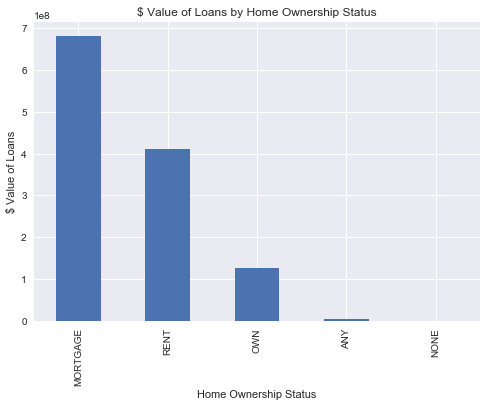

In [40]:
q117.groupby(['home_ownership']).loan_amnt.sum().sort_values(ascending=False).plot(kind='bar')

plt.ylabel('$ Value of Loans')
plt.xlabel('Home Ownership Status')
plt.title('$ Value of Loans by Home Ownership Status')

# Borrowers with a mortgage have a higher average loan size than renters or owners

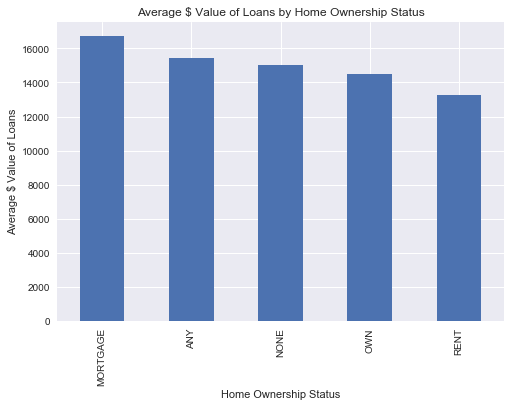

In [41]:
q117.groupby(['home_ownership']).loan_amnt.mean().sort_values(ascending=False).plot(kind='bar')

plt.ylabel('Average $ Value of Loans')
plt.xlabel('Home Ownership Status')
plt.title('Average $ Value of Loans by Home Ownership Status')

# Confirm findings from above
# Interestingly, renters have the lowest average $ value of loans

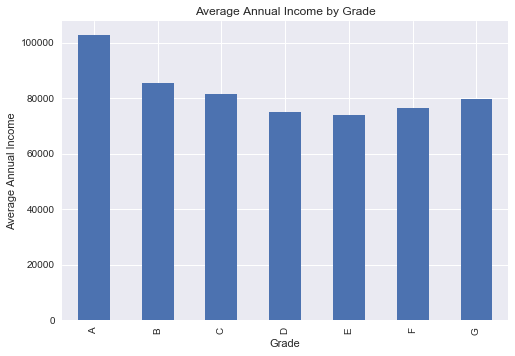

In [42]:
q117.groupby('grade').annual_inc.mean().plot(kind='bar')

plt.ylabel('Average Annual Income')
plt.xlabel('Grade')
plt.title('Average Annual Income by Grade')

# Grade A borrowers have an average annual income over $100k
# There is a larger delta between A and B annual incomes than I originally thought
# Surprisingly, annual income increases from E to G
# This shows that LC became a lot stricter with lower grade loans in order to try to fix the inverted returns curve

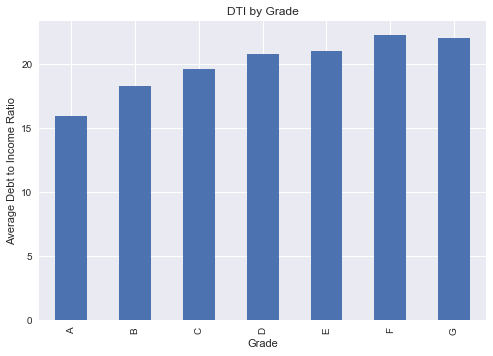

In [43]:
q117.groupby('grade').dti.mean().plot(kind='bar')

plt.ylabel('Average Debt to Income Ratio')
plt.xlabel('Grade')
plt.title('DTI by Grade')

# Unsurprisingly, lower grade borrowers have a higher average DTI than higher grade borrowers

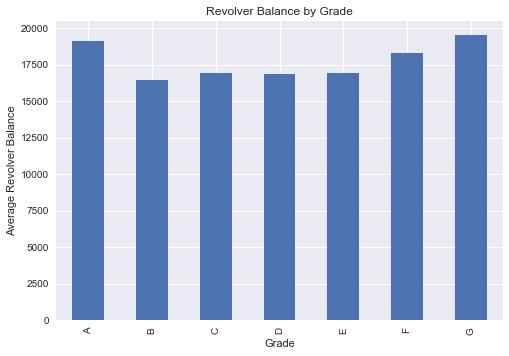

In [44]:
q117.groupby('grade').revol_bal.mean().plot(kind='bar')

plt.ylabel('Average Revolver Balance')
plt.xlabel('Grade')
plt.title('Revolver Balance by Grade')

# Not much of a pattern except that grade A borrowers have larger credit lines than other grades
# Grades F and G borrowers are likely in more debt than other borrowers, which is why they also have relatively large credit lines

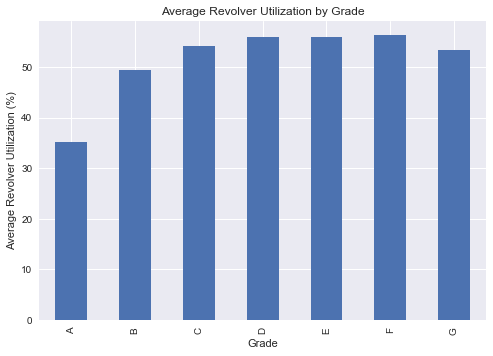

In [45]:
q117.groupby('grade').revol_util.mean().plot(kind='bar')

plt.ylabel('Average Revolver Utilization (%)')
plt.xlabel('Grade')
plt.title('Average Revolver Utilization by Grade')

# Surprisingly, grade G borrowers utilize less of their credit line than grades C through F

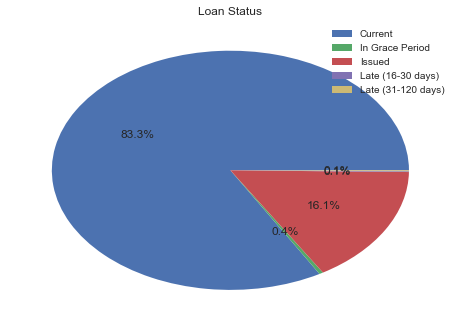

In [46]:
fig, axes = plt.subplots()
axes.pie(q117.groupby('loan_status').size(), autopct='%1.1f%%')
axes.set_title('Loan Status')
axes.legend(['Current', 'In Grace Period', 'Issued', 'Late (16-30 days)', 'Late (31-120 days)'])